#### This notebook takes an mpid and generate a Wulff construction using cgcnn predictions. 

The specific steps are below:
1. enumerate discinct facets up to miller index 2
2. Generate atomic structure of each slabs
3. Use cgcnn data structure transformer to convert atomic structures into tensors that can be feed into cgcnn
4. feed the input into cgcnn to predict surface energies of each facets
5. construct Wulff structures

## Input mpid & max_index below
!!!! this is the only input you need until further modification of the workflow

In [1]:
mpid = 'mp-126'
max_index = 2 # default is 2 for now

##### import packages 

In [2]:
import ase
import json
import multiprocess as mp
import numpy as np
import luigi
import pandas as pd
import pickle
import pymatgen_Wulff_hacked as Wulff
import skorch.callbacks.base
import tqdm
import torch

from collections import OrderedDict
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core.surface import SlabGenerator
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.ext.matproj import MPRester
api_key = 'MGOdX3P4nI18eKvE' 

from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint,lr_scheduler 
from skorch.dataset import CVSplit
from sklearn.model_selection import ShuffleSplit
from torch.optim import Adam

from gaspy import defaults
from gaspy.mongo import make_doc_from_atoms, make_atoms_from_doc
from gaspy.tasks.atoms_generators import _EnumerateDistinctFacets   # local import to avoid import errors
from gaspy.tasks import core
from gaspy.tasks import calculation_finders
from gaspy.tasks import metadata_calculators
from gaspy.utils import read_rc
GASDB_LOCATION = read_rc('gasdb_path')

#import cgcnn stuff
import cgcnn
import mongo
from cgcnn.model import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset, StructureDataTransformer

##### first check to see if bulk relaxation has been done

In [3]:
#find the bulk structure of mpid and see if the calculations has been performed
#if no relaxation was done, you'd get an error message saying no pickle file
BULK_SETTINGS = defaults.bulk_settings()
bulk_vasp_settings = BULK_SETTINGS['vasp']
bulk_task = calculation_finders.FindBulk(mpid=mpid, vasp_settings=bulk_vasp_settings)

#refresh luigi task, this is just to check if calculation has been done
# if bulk relaxation doesn't exist, then we get FileNotFoundError 
core.schedule_tasks([bulk_task])

# if relxation exist, pickle file will be regenerated from schedule_tasks, then we can get bulk documents 
bulk_doc = core.get_task_output(bulk_task)

DEBUG: Checking if FindBulk(max_fizzles=5, mpid=mp-126, vasp_settings={"ibrion": 1, "nsw": 100, "isif": 7, "isym": 0, "ediff": 1e-08, "kpts": [10, 10, 10], "prec": "Accurate", "encut": 500.0, "pp_version": "5.4", "gga": "RP", "pp": "PBE"}) is complete
INFO: Informed scheduler that task   FindBulk_5_mp_126___ibrion___1___n_fc800d147a   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=717940630, workers=1, host=cori14, username=apalizha, pid=9607) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 complete ones were encountered:
    - 1 FindBulk(...)

Did not run any tasks
This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



##### helper functions to get a list of docs of all the unique facets for an given mpid

In [4]:
def enumerate_distinct_facets(mpid, max_index):
    """
    helper function that takes on mpid and enumerate 
    the symmetrically distinct facets of a bulk material (up to index 2).
    The code is taken from gaspy.tasks.atom_generators._EnumerateDistinctFacets,
    written by Kevin Tran and Zach Ulissi.
    
    Args:
    
        mpid                A string indicating the Materials Project ID, e.g.,
                            'mp-2'
        max_miller          An integer indicating the maximum Miller index to
                            be enumerated
    """
    task = _EnumerateDistinctFacets(mpid, max_index) # make the task
    distinct_millers = core.get_task_output(task) #get the task output
    return distinct_millers

def make_slabdoc_from_bulkdoc(bulk_doc, miller_indices):
    """
    helper function that takes on the bulk_doc and miller_indices to generate unit slabs
    
    Args:
    
        bulk_doc            A list of dictionaries (also known as "documents", because
                            they'll eventually be put into Mongo as documents) that contain
                            information about the bulk.
        miller_indices      A 3-tuple containing the three Miller indices
                            of the slab[s] you want to enumerate sites from
    """
    SLAB_SETTINGS = defaults.slab_settings()
    slab_generate_settings = SLAB_SETTINGS['slab_generator_settings']
    get_slab_settings = SLAB_SETTINGS['get_slab_settings']
    bulk_atoms = make_atoms_from_doc(bulk_doc)
    bulk_structure = AseAtomsAdaptor.get_structure(bulk_atoms)
    sga = SpacegroupAnalyzer(bulk_structure, symprec=0.1)
    bulk_structure = sga.get_conventional_standard_structure()
    gen = SlabGenerator(initial_structure=bulk_structure,
                        miller_index=miller_indices,
                        **slab_generate_settings)
    
    # Generate the unit slab and find its height
    unit_slab = gen.get_slab(tol=get_slab_settings['tol'])
    slab_atoms = AseAtomsAdaptor.get_atoms(unit_slab)
    slab_doc = make_doc_from_atoms(slab_atoms)
    slab_doc['mpid'] = mpid
    slab_doc['miller'] = miller_indices
    return slab_doc

In [5]:
distinct_miller = enumerate_distinct_facets(mpid, max_index)

# generate a list of docs for all facets of that mpid
all_facets_docs = [make_slabdoc_from_bulkdoc(bulk_doc, index) for index in distinct_miller]

#since we generated unrelaxed slab, we should add another key to the doc where doc['initial_configuration'] is simply replicating doc stuff, has doc['initial_configuration'] = {atoms:{atoms:{.....}}}
# In addition, for cgcnn to work, we also need an empty dictionary for atoms final structure --> so it will pass cgcnn structuredatatransformer
#in addition, we add some additional_information
for doc in all_facets_docs:
    doc['initial_configuration'] = OrderedDict()
    doc['initial_configuration']['atoms'] = doc['atoms']
    doc['initial_configuration']['results'] = doc['results']

##### convert the atomic structure using cgcnn data transformer

In [6]:
atom_init_jsonfile = GASDB_LOCATION + 'atom_init.json'

SDT = StructureDataTransformer(atom_init_loc=atom_init_jsonfile,
                              max_num_nbr=12,
                               step=0.2,
                              radius=8,
                              use_voronoi=False,
                              use_tag=False,
                              use_fixed_info=False,
                              use_distance=False,
                              train_geometry = 'initial'
                              )

SDT_out = SDT.transform(all_facets_docs)
structures = SDT_out[0]

#Settings necessary to build the model (since they are size of vectors as inputs)
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]

SDT_out = SDT.transform(all_facets_docs)
with mp.Pool(4) as pool:
    SDT_list = list(tqdm.tqdm(pool.imap(lambda x: SDT_out[x],range(len(SDT_out)),chunksize=40),total=len(SDT_out)))

100%|██████████| 6/6 [00:00<00:00, 20.82it/s]


##### load cgcnn model parameters

In [7]:
device='cpu'

#Make a checkpoint to save parameters every time there is a new best for validation lost
cp = Checkpoint(monitor='valid_loss_best',fn_prefix='valid_best_')

#Callback to load the checkpoint with the best validation loss at the end of training
class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('valid_best_params.pt')      
load_best_valid_loss = train_end_load_best_valid_loss()

#further spilt the training data into train and validate set by 8:2 ratio for cgcnn
train_test_splitter = ShuffleSplit(test_size=0.2, random_state=42)
LR_schedule = lr_scheduler.LRScheduler('MultiStepLR',milestones=[100],gamma=0.1)

net = NeuralNetRegressor(
    CrystalGraphConvNet,
    module__orig_atom_fea_len = orig_atom_fea_len,
    module__nbr_fea_len = nbr_fea_len,
    batch_size=87,  
    module__classification=False,
    lr=np.exp(-6.465085550816676),     
    max_epochs=218,
    module__atom_fea_len=43,
    module__h_fea_len=114,
    module__n_conv=8,
    module__n_h=3, 
    optimizer=Adam,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn = collate_pool,
    iterator_train__shuffle=True, #VERY IMPORTANT
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn = collate_pool,
    iterator_valid__shuffle=False, #This should be False, which is the default
    device=device,
   criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    train_split = CVSplit(cv=train_test_splitter),
    callbacks=[cp, load_best_valid_loss, LR_schedule]
)

# load NN parameter from cgcnn
cgcnn_NN_params = GASDB_LOCATION +'surface_cgcnn_params.pkl'
net.initialize()
net.load_params(f_params=cgcnn_NN_params)

##### predict the data

In [8]:
SE_prediction = np.exp(net.predict(SDT_list).reshape(-1))
## add the prediction to docs
for prediction, doc in zip(SE_prediction, all_facets_docs):
    doc['cgcnn_prediction'] = prediction

##### wulff construction & output dataframe 

In [9]:
def wulff_shape(docs):
    """
    Construct wulff shape.
    """
    millers =[doc['miller'] for doc in docs]
    se_prediction = [round(doc['cgcnn_prediction'],3) for doc in docs]
        
    if len(millers) > 1:
        with MPRester(api_key) as m:
            structure = m.get_structure_by_material_id(mpid)
            ws_prediction = Wulff.WulffShape(structure.lattice, millers, se_prediction, symprec=1e-5)
        return ws_prediction

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


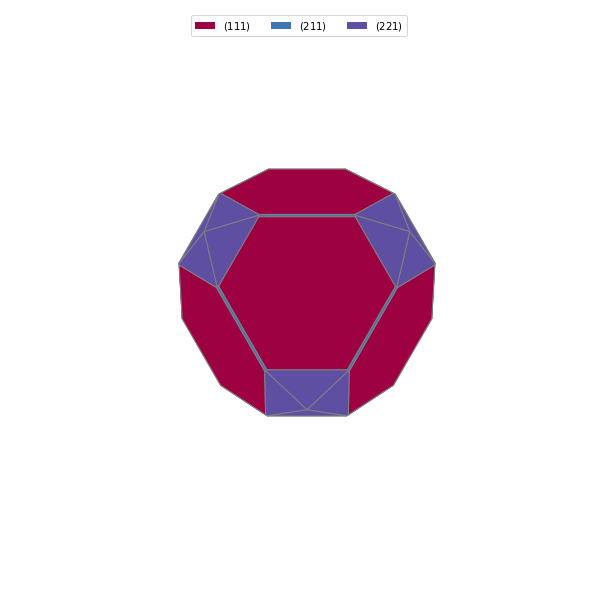

In [10]:
ws_prediction  = wulff_shape(all_facets_docs)
ws_prediction.show() 

In [11]:
# obtain the details of each facets, i.e. their surface energy and area fraction     
dicts = [ws_prediction.miller_energy_dict, ws_prediction.area_fraction_dict]
df_list = [pd.DataFrame.from_dict(d, orient='index') for d in dicts]
df = pd.concat(df_list, axis=1)
df.columns = ['Surface Energy',
              'Area Fraction']
df = df.sort_values(by='Area Fraction', ascending = False).round(3) # keep 3 sigfigs for dataframe
df

,Surface Energy,Area Fraction
"(1, 1, 1)",0.121,0.761
"(2, 2, 1)",0.149,0.223
"(2, 1, 1)",0.147,0.017
"(1, 1, 0)",0.166,0.000
"(2, 1, 0)",0.158,0.000
"(1, 0, 0)",0.134,0.000
